In [10]:
import timm
import numpy as np
import pandas as pd
import time
import torch
from tqdm.notebook import tqdm 

#import torch.utils.benchmark as benchmark
from torch.utils.data import Dataset, DataLoader

In [11]:
timm.__version__

'0.9.3dev0'

In [19]:
WARM_UP = 10
BATCH_SIZE = 4
NUM_TEST = 50

In [13]:
!nvidia-smi

Wed May 31 09:25:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:09:00.0 Off |                  Off |
| 31%   59C    P2    81W / 300W |   7386MiB / 48682MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
df_models = pd.read_csv("results-imagenet-real.csv")
# use models with img size 224
modellist = df_models[df_models["img_size"]==224]["model"]
df_models.head()

,model,top1,top1_err,top5,top5_err,param_count,img_size,crop_pct,interpolation,top1_diff,top5_diff,rank_diff
0,eva02_large_patch14_448.mim_m38m_ft_in22k_in1k,91.129,8.871,98.713,1.287,305.08,448,1.0,bicubic,1.077,-0.335,0.0
1,eva_giant_patch14_336.clip_ft_in1k,91.058,8.942,98.602,1.399,"1,013.01",336,1.0,bicubic,1.592,-0.224,5.0
2,eva02_large_patch14_448.mim_in22k_ft_in22k_in1k,91.020,8.980,98.685,1.315,305.08,448,1.0,bicubic,1.054,-0.327,-1.0
3,eva_giant_patch14_560.m30m_ft_in22k_in1k,90.969,9.031,98.672,1.328,"1,014.45",560,1.0,bicubic,1.183,-0.320,-1.0
4,eva02_large_patch14_448.mim_in22k_ft_in1k,90.922,9.078,98.683,1.317,305.08,448,1.0,bicubic,1.298,-0.267,-1.0


In [15]:
class RandomDataset(Dataset):
    def __init__(self,  length, imsize):
        self.len = length
        self.data = torch.randn( 3, imsize, imsize, length)

    def __getitem__(self, index):
        return self.data[:,:,:,index]

    def __len__(self):
        return self.len

rand_loader = DataLoader(dataset=RandomDataset(BATCH_SIZE*(WARM_UP + NUM_TEST), 224),
                         batch_size=BATCH_SIZE, shuffle=False,num_workers=8)

In [16]:
# https://github.com/ryujaehun/pytorch-gpu-benchmark/blob/master/benchmark_models.py
def inference(modelname, benchmark, half=False):
    with torch.no_grad():
        model = timm.create_model(modelname,)
        model=model.to('cuda')
        model.eval()
        precision = "float"
        durations = []
        print(f'Benchmarking Inference {modelname} ')
        for step,img in enumerate(rand_loader):
            img=getattr(img,precision)()
            torch.cuda.synchronize()
            start = time.time()
            model(img.to('cuda'))
            torch.cuda.synchronize()
            end = time.time()
            if step >= WARM_UP:
                durations.append((end - start)*1000)
        print(f'{modelname} model average inference time : {sum(durations)/len(durations)}ms')
        
        if half:
            durations_half = []
            print(f'Benchmarking Inference half precision type {modelname} ')
            model.half()
            precision = "half"
            for step,img in enumerate(rand_loader):
                img=getattr(img,precision)()
                torch.cuda.synchronize()
                start = time.time()
                model(img.to('cuda'))
                torch.cuda.synchronize()
                end = time.time()
                if step >= WARM_UP:
                    durations_half.append((end - start)*1000)
            print(f'{modelname} half model average inference time : {sum(durations_half)/len(durations_half)}ms')
            
        if half:
            benchmark[modelname] = {"fp32": np.mean(durations), "fp16": np.mean(durations_half), "top1": df_models[df_models["model"]==modelname]["top1"]}
        else:
            benchmark[modelname] = {"fp32": np.mean(durations), "top1": float(df_models[df_models["model"]==modelname]["top1"])}
    return benchmark

In [8]:
benchmark = {}

# inference float precision
for i,modelname in tqdm(enumerate((modellist))):
    try:
        benchmark = inference(modelname.split(".")[0], benchmark)
    except:
        print("pass {}".format(modelname))
benchmark

0it [00:00, ?it/s]

Benchmarking Inference eva_giant_patch14_224 
eva_giant_patch14_224 model average inference time : 75.5289077758789ms
pass eva_giant_patch14_224.clip_ft_in1k
Benchmarking Inference caformer_b36 
caformer_b36 model average inference time : 23.005459308624268ms
pass caformer_b36.sail_in22k_ft_in1k
Benchmarking Inference vit_huge_patch14_clip_224 
vit_huge_patch14_clip_224 model average inference time : 52.99990177154541ms
pass vit_huge_patch14_clip_224.laion2b_ft_in12k_in1k
Benchmarking Inference vit_large_patch14_clip_224 
vit_large_patch14_clip_224 model average inference time : 26.639528274536133ms
pass vit_large_patch14_clip_224.openai_ft_in12k_in1k


/home/ken/anaconda3/envs/pytorch_p38_2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180588308/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Benchmarking Inference beitv2_large_patch16_224 
beitv2_large_patch16_224 model average inference time : 22.335903644561768ms
pass beitv2_large_patch16_224.in1k_ft_in22k_in1k
Benchmarking Inference vit_large_patch14_clip_224 
vit_large_patch14_clip_224 model average inference time : 26.682329177856445ms
pass vit_large_patch14_clip_224.laion2b_ft_in12k_in1k
Benchmarking Inference vit_large_patch14_clip_224 
vit_large_patch14_clip_224 model average inference time : 26.756203174591064ms
pass vit_large_patch14_clip_224.openai_ft_in1k
Benchmarking Inference deit3_huge_patch14_224 
deit3_huge_patch14_224 model average inference time : 54.3524956703186ms
pass deit3_huge_patch14_224.fb_in22k_ft_in1k
Benchmarking Inference convformer_b36 
convformer_b36 model average inference time : 26.950178146362305ms
pass convformer_b36.sail_in22k_ft_in1k
Benchmarking Inference vit_huge_patch14_clip_224 
vit_huge_patch14_clip_224 model average inference time : 53.39716672897339ms
pass vit_huge_patch14_clip_

Benchmarking Inference convformer_b36 
convformer_b36 model average inference time : 27.112410068511963ms
pass convformer_b36.sail_in1k
Benchmarking Inference coatnet_rmlp_1_rw2_224 
coatnet_rmlp_1_rw2_224 model average inference time : 15.502762794494629ms
pass coatnet_rmlp_1_rw2_224.sw_in12k_ft_in1k
Benchmarking Inference resnext101_32x16d 
resnext101_32x16d model average inference time : 30.904955863952637ms
pass resnext101_32x16d.fb_wsl_ig1b_ft_in1k
Benchmarking Inference swin_small_patch4_window7_224 
swin_small_patch4_window7_224 model average inference time : 12.081964015960693ms
pass swin_small_patch4_window7_224.ms_in22k_ft_in1k
Benchmarking Inference xcit_medium_24_p16_224 
xcit_medium_24_p16_224 model average inference time : 18.137314319610596ms
pass xcit_medium_24_p16_224.fb_dist_in1k
Benchmarking Inference convformer_m36 
convformer_m36 model average inference time : 19.74210023880005ms
pass convformer_m36.sail_in1k
Benchmarking Inference resnext101_32x8d 
resnext101_32x8

/home/ken/anaconda3/envs/pytorch_p38_2/lib/python3.8/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


efficientformerv2_l model average inference time : 19.756417274475098ms
pass efficientformerv2_l.snap_dist_in1k
Benchmarking Inference gcvit_base 
gcvit_base model average inference time : 18.81230592727661ms
pass gcvit_base.in1k
Benchmarking Inference convformer_s36 
convformer_s36 model average inference time : 17.91667938232422ms
pass convformer_s36.sail_in1k
Benchmarking Inference maxvit_large_tf_224 
pass maxvit_large_tf_224.in1k
Benchmarking Inference maxvit_small_tf_224 
pass maxvit_small_tf_224.in1k
Benchmarking Inference cait_s24_224 
cait_s24_224 model average inference time : 13.369269371032715ms
pass cait_s24_224.fb_dist_in1k
Benchmarking Inference resmlp_big_24_224 
resmlp_big_24_224 model average inference time : 33.98709297180176ms
pass resmlp_big_24_224.fb_distilled_in1k
Benchmarking Inference vit_large_r50_s32_224 
vit_large_r50_s32_224 model average inference time : 17.629268169403076ms
pass vit_large_r50_s32_224.augreg_in21k_ft_in1k
Benchmarking Inference regnety_320

Benchmarking Inference coat_small 
coat_small model average inference time : 20.749013423919678ms
pass coat_small.in1k
Benchmarking Inference xcit_medium_24_p8_224 
xcit_medium_24_p8_224 model average inference time : 43.43877553939819ms
pass xcit_medium_24_p8_224.fb_in1k
Benchmarking Inference resnext101_32x16d 
resnext101_32x16d model average inference time : 30.86660385131836ms
pass resnext101_32x16d.fb_swsl_ig1b_ft_in1k
Benchmarking Inference resnext50_32x4d 
resnext50_32x4d model average inference time : 7.076573371887207ms
pass resnext50_32x4d.fb_swsl_ig1b_ft_in1k
Benchmarking Inference nest_base_jx 
nest_base_jx model average inference time : 13.149569034576416ms
pass nest_base_jx.goog_in1k
Benchmarking Inference davit_tiny 
davit_tiny model average inference time : 7.576360702514648ms
pass davit_tiny.msft_in1k
Benchmarking Inference levit_384 
levit_384 model average inference time : 8.327574729919434ms
pass levit_384.fb_dist_in1k
Benchmarking Inference levit_conv_384 
levit_co

Benchmarking Inference deit3_small_patch16_224 
deit3_small_patch16_224 model average inference time : 5.5252838134765625ms
pass deit3_small_patch16_224.fb_in1k
Benchmarking Inference swinv2_cr_tiny_ns_224 
swinv2_cr_tiny_ns_224 model average inference time : 8.393325805664062ms
pass swinv2_cr_tiny_ns_224.sw_in1k
Benchmarking Inference coatnet_nano_rw_224 
coatnet_nano_rw_224 model average inference time : 9.576084613800049ms
pass coatnet_nano_rw_224.sw_in1k
Benchmarking Inference resmlp_36_224 
resmlp_36_224 model average inference time : 7.661442756652832ms
pass resmlp_36_224.fb_distilled_in1k
Benchmarking Inference poolformer_m36 
poolformer_m36 model average inference time : 16.079864501953125ms
pass poolformer_m36.sail_in1k
Benchmarking Inference regnety_032 
regnety_032 model average inference time : 12.137482166290283ms
pass regnety_032.tv2_in1k
Benchmarking Inference xcit_large_24_p16_224 
xcit_large_24_p16_224 model average inference time : 18.75328540802002ms
pass xcit_large_

Benchmarking Inference resnext50_32x4d 
resnext50_32x4d model average inference time : 6.948068141937256ms
pass resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k
Benchmarking Inference res2net101d 
res2net101d model average inference time : 18.28681468963623ms
pass res2net101d.in1k
Benchmarking Inference resnet101s 
resnet101s model average inference time : 10.966188907623291ms
pass resnet101s.gluon_in1k
Benchmarking Inference seresnext101_32x4d 
seresnext101_32x4d model average inference time : 17.70906686782837ms
pass seresnext101_32x4d.gluon_in1k
Benchmarking Inference poolformer_s24 
poolformer_s24 model average inference time : 8.454699516296387ms
pass poolformer_s24.sail_in1k
Benchmarking Inference resnet152 
resnet152 model average inference time : 15.603017807006836ms
pass resnet152.a3_in1k
Benchmarking Inference seresnext101_64x4d 
seresnext101_64x4d model average inference time : 20.45177459716797ms
pass seresnext101_64x4d.gluon_in1k
Benchmarking Inference efficientformerv2_s1 
efficie

Benchmarking Inference resnext50_32x4d 
resnext50_32x4d model average inference time : 6.8968915939331055ms
pass resnext50_32x4d.gluon_in1k
Benchmarking Inference tf_efficientnet_b0 
tf_efficientnet_b0 model average inference time : 7.124233245849609ms
pass tf_efficientnet_b0.ns_jft_in1k
Benchmarking Inference coat_tiny 
coat_tiny model average inference time : 68.7386417388916ms
pass coat_tiny.in1k
Benchmarking Inference regnety_040 
regnety_040 model average inference time : 12.902524471282959ms
pass regnety_040.pycls_in1k
Benchmarking Inference dla169 
dla169 model average inference time : 16.4713191986084ms
pass dla169.in1k
Benchmarking Inference resnet50d 
resnet50d model average inference time : 6.223800182342529ms
pass resnet50d.a3_in1k
Benchmarking Inference legacy_seresnext50_32x4d 
legacy_seresnext50_32x4d model average inference time : 9.208266735076904ms
pass legacy_seresnext50_32x4d.in1k
Benchmarking Inference hrnet_w44 
hrnet_w44 model average inference time : 32.02947854

regnety_016 model average inference time : 18.524765968322754ms
pass regnety_016.pycls_in1k
Benchmarking Inference resnext50_32x4d 
resnext50_32x4d model average inference time : 6.988542079925537ms
pass resnext50_32x4d.tv_in1k
Benchmarking Inference resnet50 
resnet50 model average inference time : 6.067063808441162ms
pass resnet50.gluon_in1k
Benchmarking Inference densenet161 
densenet161 model average inference time : 18.100674152374268ms
pass densenet161.tv_in1k
Benchmarking Inference mobilenetv2_120d 
mobilenetv2_120d model average inference time : 6.5221476554870605ms
pass mobilenetv2_120d.ra_in1k
Benchmarking Inference resnet101 
resnet101 model average inference time : 10.733718872070312ms
pass resnet101.tv_in1k
Benchmarking Inference dpn68b 
dpn68b model average inference time : 10.912940502166748ms
pass dpn68b.mx_in1k
Benchmarking Inference hardcorenas_d 
hardcorenas_d model average inference time : 7.697744369506836ms
pass hardcorenas_d.miil_green_in1k
Benchmarking Inference

pit_ti_distilled_224 model average inference time : 14.24842357635498ms
pass pit_ti_distilled_224.in1k
Benchmarking Inference densenet121 
densenet121 model average inference time : 13.54733943939209ms
pass densenet121.tv_in1k
Benchmarking Inference regnety_006 
regnety_006 model average inference time : 8.220255374908447ms
pass regnety_006.pycls_in1k
Benchmarking Inference regnetx_004_tv 
regnetx_004_tv model average inference time : 8.409786224365234ms
pass regnetx_004_tv.tv2_in1k
Benchmarking Inference dla34 
dla34 model average inference time : 4.670431613922119ms
pass dla34.in1k
Benchmarking Inference xcit_nano_12_p8_224 
xcit_nano_12_p8_224 model average inference time : 10.20376443862915ms
pass xcit_nano_12_p8_224.fb_in1k
Benchmarking Inference fbnetc_100 
fbnetc_100 model average inference time : 5.674831867218018ms
pass fbnetc_100.rmsp_in1k
Benchmarking Inference legacy_seresnet34 
legacy_seresnet34 model average inference time : 6.83682918548584ms
pass legacy_seresnet34.in1k


tf_mobilenetv3_small_minimal_100 model average inference time : 3.430161476135254ms
pass tf_mobilenetv3_small_minimal_100.in1k
Benchmarking Inference mobilenetv3_small_050 
mobilenetv3_small_050 model average inference time : 4.711909294128418ms
pass mobilenetv3_small_050.lamb_in1k


{'tnt_s_patch16_224': {'fp32': 11.72980785369873, 'top1': 86.914}}

In [9]:
df_results = pd.DataFrame(benchmark).T
df_results

,fp32,top1
tnt_s_patch16_224,11.729808,86.914


In [10]:
df_results.to_csv("results_fp32_224.csv")

## plot

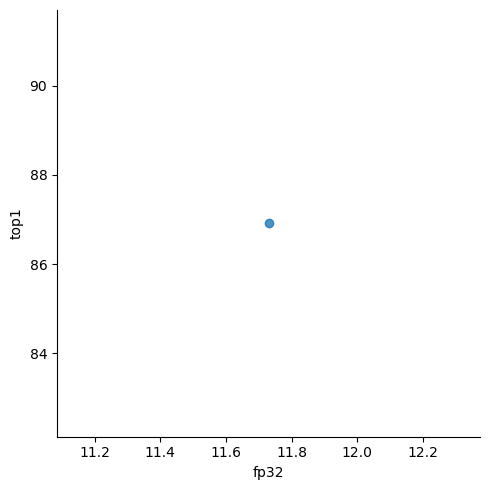

In [11]:
import seaborn as sns
sns.lmplot(y='top1', x='fp32',  
           data=df_results, logx=True,
           fit_reg=False, scatter_kws={'alpha':0.8})

# For various image size

In [17]:
# https://github.com/ryujaehun/pytorch-gpu-benchmark/blob/master/benchmark_models.py
def inference_imsize(modelname, benchmark, imsize):
    with torch.no_grad():
        model = timm.create_model(modelname.split(".")[0])
        model=model.to('cuda')
        model.eval()
        precision = "float"
        durations = []
        rand_loader = DataLoader(dataset=RandomDataset(BATCH_SIZE*(WARM_UP + NUM_TEST), imsize),
                         batch_size=BATCH_SIZE, shuffle=False,num_workers=8)
        print(f'Benchmarking Inference {modelname} ')
        for step,img in enumerate(rand_loader):
            img=getattr(img,precision)()
            torch.cuda.synchronize()
            start = time.time()
            model(img.to('cuda'))
            torch.cuda.synchronize()
            end = time.time()
            if step >= WARM_UP:
                durations.append((end - start)*1000)
        print(f'{modelname} model average inference time : {sum(durations)/len(durations)}ms')
        
        benchmark[modelname] = {"fp32": np.mean(durations), "top1": float(df_models[df_models["model"]==modelname]["top1"]), "imsize": imsize}
    return benchmark

In [ ]:
modellist = df_models["model"]
benchmark = {}

# inference float precision
for i,modelname in tqdm(enumerate((modellist))):
    imsize = int(df_models[df_models["model"]==modelname]["img_size"])
    try:
        benchmark = inference_imsize(modelname, benchmark, imsize)
    except:
        print("pass {}".format(modelname))
benchmark

0it [00:00, ?it/s]

Benchmarking Inference eva02_large_patch14_448.mim_m38m_ft_in22k_in1k 
eva02_large_patch14_448.mim_m38m_ft_in22k_in1k model average inference time : 171.2168550491333ms
Benchmarking Inference eva_giant_patch14_336.clip_ft_in1k 
eva_giant_patch14_336.clip_ft_in1k model average inference time : 166.4306116104126ms
Benchmarking Inference eva02_large_patch14_448.mim_in22k_ft_in22k_in1k 
eva02_large_patch14_448.mim_in22k_ft_in22k_in1k model average inference time : 171.71310424804688ms
Benchmarking Inference eva_giant_patch14_560.m30m_ft_in22k_in1k 
eva_giant_patch14_560.m30m_ft_in22k_in1k model average inference time : 581.2683391571045ms
Benchmarking Inference eva02_large_patch14_448.mim_in22k_ft_in1k 
eva02_large_patch14_448.mim_in22k_ft_in1k model average inference time : 172.71728515625ms
Benchmarking Inference eva_giant_patch14_336.m30m_ft_in22k_in1k 
eva_giant_patch14_336.m30m_ft_in22k_in1k model average inference time : 168.33984851837158ms
Benchmarking Inference eva_large_patch14_3

Benchmarking Inference convnext_large_mlp.clip_laion2b_augreg_ft_in1k 
convnext_large_mlp.clip_laion2b_augreg_ft_in1k model average inference time : 18.87547016143799ms
Benchmarking Inference vit_large_patch14_clip_224.openai_ft_in1k 
vit_large_patch14_clip_224.openai_ft_in1k model average inference time : 26.78530216217041ms
Benchmarking Inference caformer_s36.sail_in22k_ft_in1k_384 
caformer_s36.sail_in22k_ft_in1k_384 model average inference time : 41.20553493499756ms
Benchmarking Inference convnext_base.fb_in22k_ft_in1k_384 
convnext_base.fb_in22k_ft_in1k_384 model average inference time : 25.742578506469727ms
Benchmarking Inference convnext_large.fb_in22k_ft_in1k_384 
convnext_large.fb_in22k_ft_in1k_384 model average inference time : 41.74063682556152ms
Benchmarking Inference deit3_large_patch16_384.fb_in22k_ft_in1k 
deit3_large_patch16_384.fb_in22k_ft_in1k model average inference time : 64.4304370880127ms
Benchmarking Inference dm_nfnet_f6.dm_in1k 
dm_nfnet_f6.dm_in1k model averag

Benchmarking Inference convformer_m36.sail_in22k_ft_in1k 
convformer_m36.sail_in22k_ft_in1k model average inference time : 19.892358779907227ms
Benchmarking Inference xcit_medium_24_p8_384.fb_dist_in1k 
xcit_medium_24_p8_384.fb_dist_in1k model average inference time : 108.35433959960938ms
Benchmarking Inference convnext_base.clip_laion2b_augreg_ft_in12k_in1k 
convnext_base.clip_laion2b_augreg_ft_in12k_in1k model average inference time : 11.771078109741211ms
Benchmarking Inference volo_d4_224.sail_in1k 
volo_d4_224.sail_in1k model average inference time : 24.9357271194458ms
Benchmarking Inference maxvit_large_tf_512.in1k 
pass maxvit_large_tf_512.in1k
Benchmarking Inference vit_large_r50_s32_384.augreg_in21k_ft_in1k 
vit_large_r50_s32_384.augreg_in21k_ft_in1k model average inference time : 29.021129608154297ms
Benchmarking Inference volo_d2_384.sail_in1k 
volo_d2_384.sail_in1k model average inference time : 42.049713134765625ms
Benchmarking Inference swin_large_patch4_window7_224.ms_in2

Benchmarking Inference convnextv2_base.fcmae_ft_in1k 
convnextv2_base.fcmae_ft_in1k model average inference time : 21.80408477783203ms
Benchmarking Inference caformer_b36.sail_in1k 
caformer_b36.sail_in1k model average inference time : 23.217487335205078ms
Benchmarking Inference vit_base_patch16_clip_224.openai_ft_in12k_in1k 
vit_base_patch16_clip_224.openai_ft_in12k_in1k model average inference time : 7.255816459655762ms
Benchmarking Inference hrnet_w48_ssld.paddle_in1k 
hrnet_w48_ssld.paddle_in1k model average inference time : 32.19280242919922ms
Benchmarking Inference beit_base_patch16_224.in22k_ft_in22k_in1k 
beit_base_patch16_224.in22k_ft_in22k_in1k model average inference time : 7.8772735595703125ms
Benchmarking Inference regnetz_e8.ra3_in1k 
regnetz_e8.ra3_in1k model average inference time : 29.124879837036133ms
Benchmarking Inference deit3_small_patch16_384.fb_in22k_ft_in1k 
deit3_small_patch16_384.fb_in22k_ft_in1k model average inference time : 11.160078048706055ms
Benchmarkin

convnext_tiny.fb_in22k_ft_in1k_384 model average inference time : 12.775044441223145ms
Benchmarking Inference regnetz_d8.ra3_in1k 
regnetz_d8.ra3_in1k model average inference time : 15.848784446716309ms
Benchmarking Inference convformer_b36.sail_in1k 
convformer_b36.sail_in1k model average inference time : 27.05242156982422ms
Benchmarking Inference coatnet_rmlp_1_rw2_224.sw_in12k_ft_in1k 
coatnet_rmlp_1_rw2_224.sw_in12k_ft_in1k model average inference time : 15.46870231628418ms
Benchmarking Inference resnetrs420.tf_in1k 
resnetrs420.tf_in1k model average inference time : 93.55855941772461ms
Benchmarking Inference resnext101_32x16d.fb_wsl_ig1b_ft_in1k 
resnext101_32x16d.fb_wsl_ig1b_ft_in1k model average inference time : 30.859827995300293ms
Benchmarking Inference resnetrs270.tf_in1k 
resnetrs270.tf_in1k model average inference time : 46.121697425842285ms
Benchmarking Inference vit_small_r26_s32_384.augreg_in21k_ft_in1k 
vit_small_r26_s32_384.augreg_in21k_ft_in1k model average inference 

In [ ]:
df_results = pd.DataFrame(benchmark).T
df_results
df_results.to_csv("results_fp32_imsizeall.csv")

In [ ]:
df_results